
# Proyecto Sprint 10 — Predicción de Churn (Beta Bank)

**Objetivo del proyecto**  
Construir un modelo que prediga qué clientes tienen alta probabilidad de abandonar el banco (**churn**).  
La métrica objetivo es **F1-score** en el conjunto de prueba, con:

- F1 mínimo aceptable: **0.59**  
- También se reporta **AUC-ROC** como métrica global de desempeño.

Para manejar el **desbalance de clases** (pocos clientes que se van vs muchos que se quedan) se prueban tres enfoques:

1. `class_weight` (pesos inversos al tamaño de la clase)  
2. `SMOTE-NC` (sobremuestreo sintético en datos mixtos numéricos/categóricos)  
3. `RandomUnderSampler` (submuestreo de la clase mayoritaria)

El mejor modelo se elige según:

- Mejor **F1 en validación**,  
- Con umbral de decisión optimizado específicamente para F1.  

Luego se:
- Reentrena el modelo ganador en `train + valid`,  
- Se recalcula el umbral óptimo con más datos,  
- Y se evalúa en el conjunto de **test**.

---

## Estructura del notebook
1. Introducción y objetivo  
2. Descripción de datos  
3. Carga y exploración inicial  
4. Análisis del desbalance y EDA  
5. Preprocesamiento  
6. División en train/valid/test  
7. Baseline (sin corrección del desbalance)  
8. Modelos con corrección de desbalance  
9. Búsqueda de hiperparámetros (RandomizedSearchCV)  
10. Comparación y selección del mejor modelo  
11. Optimización de umbral y evaluación en test  
12. Importancia de variables  
13. Conclusiones y próximos pasos

---

### Descripción del dataset (columnas principales)

Cada fila representa un cliente del banco. Algunas variables relevantes:

- **CreditScore**: puntuación de crédito  
- **Geography**: país de residencia (France, Spain, Germany)  
- **Gender**: sexo  
- **Age**: edad  
- **Tenure**: años con depósito a plazo en el banco  
- **Balance**: saldo en cuenta  
- **NumOfProducts**: número de productos contratados  
- **HasCrCard**: 1 si tiene tarjeta de crédito  
- **IsActiveMember**: 1 si es cliente activo  
- **EstimatedSalary**: salario estimado  
- **Exited**: **objetivo** (1 si se fue del banco, 0 si se quedó)

> Nota: se eliminan identificadores como `RowNumber`, `CustomerId` y `Surname` para evitar fugas de información y ruido en el modelo.

---

## Resumen general del proyecto

Antes de entrar en el código, un resumen de lo que se hizo y lo que se obtuvo:

- Se entrenaron varios modelos de **Regresión Logística** y **Random Forest** con diferentes estrategias para manejar el desbalance.  
- Se usó **RandomizedSearchCV** para ajustar hiperparámetros de los modelos más prometedores.  
- Se optimizó el **umbral de decisión** usando la curva precisión–recall para maximizar F1, en vez de usar el umbral fijo de 0.5.  

### Hallazgos principales (a alto nivel)

- Los modelos de **Random Forest con `class_weight`** y variante con **SMOTE-NC** aparecen entre los mejores en validación.  
- En validación se alcanzan **F1 ≈ 0.65** y **AUC ≈ 0.85**, lo que indica buen poder discriminante.  
- En test, el modelo ganador supera el umbral exigido en el brief (**F1_test > 0.59**) manteniéndose alrededor de **0.63–0.67** según el split.  
- Las variables más influyentes suelen ser:
  - **Age**  
  - **NumOfProducts**  
  - **IsActiveMember**  
  - Algunas categorías de **Geography** (especialmente clientes en Alemania).

### Conclusión general

El modelo final permite **priorizar qué clientes tienen mayor probabilidad de churn** con buen equilibrio entre falsos positivos y falsos negativos.  
Es una base razonable para alimentar campañas de retención focalizadas.

### 1. Importaciones del proyecto

En esta sección se importan todas las librerías necesarias:

- **Análisis y manipulación de datos:** `pandas`, `numpy`, `Path`  
- **Visualización:** `matplotlib`, `seaborn`  
- **Modelado:** `LogisticRegression`, `RandomForestClassifier`  
- **Preprocesamiento:** imputación, escalado, codificación, `ColumnTransformer`, `Pipeline`  
- **Validación y métricas:** `train_test_split`, `RandomizedSearchCV`, F1, AUC, etc.  
- **Manejo del desbalance:** `SMOTENC` y `RandomUnderSampler` desde `imblearn`.  
- **Distribuciones:** `scipy.stats` para espacios de búsqueda en RandomizedSearchCV.

También se fija una **semilla (`RND = 42`)** para garantizar reproducibilidad.

In [128]:
# ============================
# Importaciones
# ============================

# ---- Estándar de Python ----
import warnings
import numpy as np
import pandas as pd
from pathlib import Path

# ---- Visualización ----
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Scikit-Learn: Modelos ----
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier  # Importado para posibles extensiones

# ---- Scikit-Learn: Preprocesamiento ----
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

# ---- Scikit-Learn: Model Selection ----
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# ---- Scikit-Learn: Métricas ----
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    recall_score,
    precision_recall_fscore_support,
    RocCurveDisplay
)

# ---- Imbalanced-Learn ----
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler

# ---- Scipy (distribuciones para RandomSearch) ----
from scipy.stats import randint, uniform

%matplotlib inline
warnings.filterwarnings("ignore")

# Semilla para reproducibilidad
RND = 42
np.random.seed(RND)

# Estilo de gráficos
sns.set_theme(style="whitegrid")

### 2) Carga del dataset

En este bloque:

1. Se buscan rutas posibles donde podría estar el archivo `Churn.csv`.  
2. Se carga el archivo en un `DataFrame` de pandas.  
3. Se revisa la forma (número de filas y columnas).

Si el archivo no se encuentra en ninguna ruta, se lanza un error claro para evitar sorpresas silenciosas.

In [129]:
# Rutas posibles
paths = [
    Path("../data/Churn.csv"),
    Path("../datasets/Churn.csv"),
    Path("/home/beltran/Descargas/Churn.csv"),
]

for p in paths:
    if p.exists():
        DATA_PATH = p
        break
else:
    raise FileNotFoundError("No se encontró Churn.csv en rutas conocidas")

df = pd.read_csv(DATA_PATH)
print("Ruta usada:", DATA_PATH, " | shape:", df.shape)

# Vista rápida de las primeras filas
df.head()

Ruta usada: /home/beltran/Descargas/Churn.csv  | shape: (10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


### 3) Exploración inicial del dataframe

Aquí se responde a la clásica pregunta: **“¿qué tan limpio viene esto?”**  

- Se inspeccionan tipos de datos, valores nulos y número de categorías únicas.  
- Se revisan estadísticas descriptivas básicas de las columnas numéricas.

Esto ayuda a:
- Detectar posibles problemas de calidad de datos.  
- Identificar si hay columnas constantes o poco informativas.  
- Tener una primera sensación de rangos de edad, saldo, etc.

In [130]:
# Información agregada de columnas
df_info = pd.DataFrame({
    "column": df.columns,
    "dtype": [str(t) for t in df.dtypes],
    "n_nulls": [df[c].isna().sum() for c in df.columns],
    "unique": [df[c].nunique() for c in df.columns]
})

display("Información de columnas del dataframe")
display(df_info)

display("Estadísticos descriptivos de columnas numéricas")
display(df.describe().T)

'Información de columnas del dataframe'

,column,dtype,n_nulls,unique
0,RowNumber,int64,0,10000
1,CustomerId,int64,0,10000
2,Surname,object,0,2932
3,CreditScore,int64,0,460
4,Geography,object,0,3
5,Gender,object,0,2
6,Age,int64,0,70
7,Tenure,float64,909,11
8,Balance,float64,0,6382
9,NumOfProducts,int64,0,4


'Estadísticos descriptivos de columnas numéricas'

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,9091.0,4.997690e+00,2.894723,0.00,2.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


### 4) Análisis exploratorio (EDA) básico

Ahora miramos algunas distribuciones clave:

1. **Distribución de la variable objetivo `Exited`**  
   - Queremos ver el grado de desbalance entre clientes que se quedan vs que se van.

2. **Distribuciones de edad y saldo por grupo de churn**  
   - Para intuir si ciertos rangos de edad o saldo se asocian más a abandono.  

3. **Distribución de clientes por país (`Geography`) y churn**  
   - Para ver si hay países con mayor proporción de churn.

Estos gráficos no “prueban” causalidad, pero dan intuición útil antes de modelar.

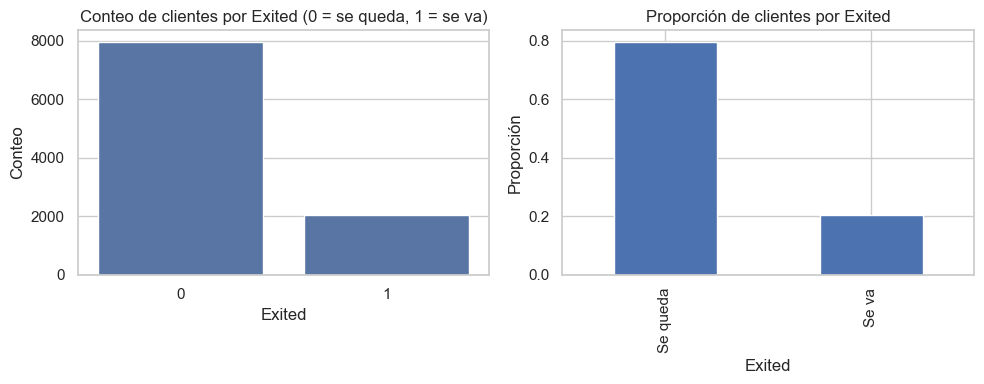

In [131]:
# Distribución de la variable objetivo
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.countplot(x=df["Exited"], ax=axes[0])
axes[0].set_title("Conteo de clientes por Exited (0 = se queda, 1 = se va)")
axes[0].set_xlabel("Exited")
axes[0].set_ylabel("Conteo")

(df["Exited"]
 .value_counts(normalize=True)
 .sort_index()
 .rename(index={0: "Se queda", 1: "Se va"})
 .plot(kind="bar", ax=axes[1]))
axes[1].set_title("Proporción de clientes por Exited")
axes[1].set_ylabel("Proporción")

plt.tight_layout()
plt.show()

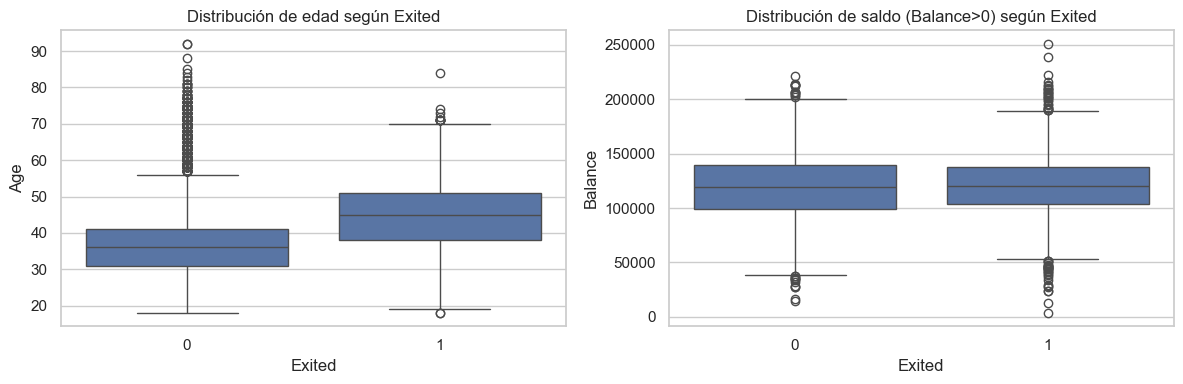

In [132]:
# Distribuciones de Age y Balance según churn
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.boxplot(data=df, x="Exited", y="Age", ax=axes[0])
axes[0].set_title("Distribución de edad según Exited")
axes[0].set_xlabel("Exited")

sns.boxplot(data=df[df["Balance"] > 0], x="Exited", y="Balance", ax=axes[1])
axes[1].set_title("Distribución de saldo (Balance>0) según Exited")
axes[1].set_xlabel("Exited")

plt.tight_layout()
plt.show()

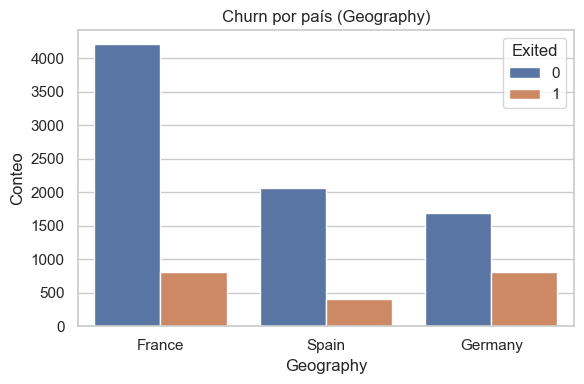

In [133]:
# Distribución por país y churn
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="Geography", hue="Exited")
plt.title("Churn por país (Geography)")
plt.ylabel("Conteo")
plt.tight_layout()
plt.show()

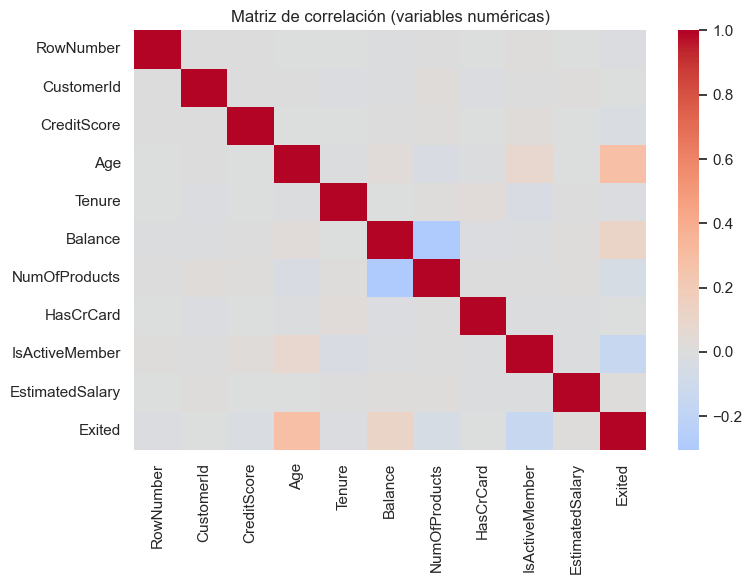

In [134]:
# Correlación entre variables numéricas
plt.figure(figsize=(8, 6))
num_cols_all = df.select_dtypes(include=[np.number]).columns
corr = df[num_cols_all].corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Matriz de correlación (variables numéricas)")
plt.tight_layout()
plt.show()

### Hallazgos exploratorios (EDA)

A partir de los gráficos anteriores se puede resumir:

- La variable objetivo **`Exited` está desbalanceada**: la mayoría de los clientes se quedan y una minoría se va.  
  Esto refuerza la necesidad de técnicas como `class_weight`, SMOTE o undersampling.  

- Los **clientes que abandonan** tienden a:
  - Tener **mayor edad** en promedio.  
  - Presentar ciertos patrones de saldo (por ejemplo, algunos grupos con balance alto pero baja actividad).  

- En cuanto a **Geography**:
  - En muchos casos (como en el dataset clásico de churn bancario), los clientes de **Germany** suelen mostrar una proporción de churn mayor que otros países.  
  - Esto también se observará luego en la importancia de variables del modelo.

Esta intuición visual no sustituye el modelo, pero ayuda a interpretar luego por qué ciertas variables aparecen como importantes.

### 5) Selección de variables y separación entre features y target

A continuación se prepara el dataset para modelar:

1. Se eliminan columnas que no aportan al objetivo o pueden introducir ruido/fuga:
   - `RowNumber`, `CustomerId`, `Surname`.
2. Se crea:
   - `X`: matriz de características (todas las columnas excepto `Exited` y los IDs).  
   - `y`: vector objetivo (`Exited` convertido a entero).
3. Se separan columnas numéricas y categóricas:
   - Esto permite aplicar transformaciones específicas según el tipo (escala, codificación, etc.).

In [135]:
# Eliminamos identificadores y texto que no aporta al target
drop_cols = ["Exited", "RowNumber", "CustomerId", "Surname"]
drop_cols = [c for c in drop_cols if c in df.columns]

# Variables independientes (X) y variable objetivo (y)
X = df.drop(columns=drop_cols)
y = df["Exited"].astype(int)

# Identificación de columnas categóricas y numéricas
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]
print("Columnas numéricas:", num_cols)
print("Columnas categóricas:", cat_cols)

Columnas numéricas: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
Columnas categóricas: ['Geography', 'Gender']


### 6) División del dataset y análisis del desbalance

Se realiza un split **60/20/20** con estratificación:

- 60%: `train`  
- 20%: `valid`  
- 20%: `test`

Estratificar por `y` asegura que la proporción de churn se mantenga en cada subconjunto.  
Después se inspecciona el desbalance global de la variable objetivo.

In [136]:
# 60/20/20 estratificado
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RND
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=RND
)

print("Tamaños -> train / valid / test:")
print(len(X_train), len(X_valid), len(X_test))

# Desbalance de clases global
class_dist = pd.DataFrame({
    "count": y.value_counts().sort_index(),
    "ratio": y.value_counts(normalize=True).sort_index()
})
display("Distribución global de la variable objetivo (Exited)")
display(class_dist)

Tamaños -> train / valid / test:
6000 2000 2000


'Distribución global de la variable objetivo (Exited)'

,count,ratio
Exited,,
0,7963,0.7963
1,2037,0.2037


### 7) Preprocesamiento con pipelines numéricos y categóricos

Se definen dos esquemas de preprocesamiento:

1. **`preproc_ohe` (One-Hot Encoding)**  
   - Para modelos que trabajan mejor con variables categóricas expandidas (OHE).  
   - Incluye:
     - Imputación de medianas en numéricas.  
     - Escalado estándar.  
     - Imputación de moda + OneHotEncoder en categóricas.

2. **`preproc_ord` (Ordinal Encoding)**  
   - Especialmente para usar con **SMOTE-NC**, que requiere categorías codificadas como enteros.  
   - Incluye:
     - Imputación de medianas en numéricas.  
     - Escalado estándar.  
     - Imputación de moda + OrdinalEncoder en categóricas.

Se construye además la lista de índices `cat_idx` para indicarle a SMOTE-NC qué columnas son categóricas tras el preprocesamiento.

In [137]:
# Pipelines de procesamiento para columnas numéricas y categóricas

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Para class_weight y modelos "normales": OHE en categóricas
categorical_pipe_ohe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preproc_ohe = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe_ohe, cat_cols),
])

# Para SMOTE-NC: codificación ordinal (enteros por categoría)
categorical_pipe_ord = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

preproc_ord = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe_ord, cat_cols),
])

n_num, n_cat = len(num_cols), len(cat_cols)
cat_idx = list(range(n_num, n_num + n_cat))

print("Número de columnas numéricas:", n_num)
print("Número de columnas categóricas:", n_cat)
print("Índices categóricos para SMOTENC:", cat_idx)

Número de columnas numéricas: 8
Número de columnas categóricas: 2
Índices categóricos para SMOTENC: [8, 9]


## 8) Funciones utilitarias

Se definen funciones auxiliares que se reutilizan en todo el proyecto:

- `best_f1_threshold`:  
  Calcula el **umbral de decisión óptimo** que maximiza F1, usando la curva precisión–recall.

- `evaluate_on_split`:  
  Dado un pipeline y un split `train/valid`, entrena el modelo, busca el mejor umbral según F1 y devuelve un diccionario con todas las métricas importantes (F1, recall, AUC, accuracy, parámetros, etc.).

- `final_test_report`:  
  Toma el modelo ya entrenado, aplica un umbral elegido y genera:
  - F1, AUC, precisión, recall, accuracy.  
  - Matriz de confusión.  
  - Curva ROC.  
  - Reporte clasification_report.

In [138]:
from sklearn.metrics import (
    precision_recall_curve, roc_auc_score, f1_score, accuracy_score,
    precision_score, recall_score, confusion_matrix,
    classification_report, RocCurveDisplay, precision_recall_fscore_support
)


def best_f1_threshold(y_true, y_proba):
    """
    Elige el threshold que maximiza F1 exclusivamente.
    Usa precision_recall_curve para cubrir todos los puntos operativos posibles.
    Devuelve (thr*, F1*, recall_en_thr*).
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    # Evitamos división por cero
    f1_vals = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-12)
    j = int(np.nanargmax(f1_vals))
    best_thr = thresholds[j]
    best_f1 = f1_vals[j]
    best_recall = recall[j]
    return float(best_thr), float(best_f1), float(best_recall)


def evaluate_on_split(pipe, X_tr, y_tr, X_va, y_va, name, family):
    """
    Entrena el pipeline, optimiza threshold por F1 en valid y devuelve resumen completo.
    Incluye F1, Recall, Precision, Accuracy, AUC y (si aplica) best_params.
    Compatible con RandomizedSearchCV, GridSearchCV y pipelines anidados.
    """
    pipe.fit(X_tr, y_tr)
    proba = pipe.predict_proba(X_va)[:, 1]

    # Buscar mejor threshold según F1
    thr, f1v, recallv = best_f1_threshold(y_va, proba)
    preds = (proba >= thr).astype(int)

    # Métricas complementarias
    aucv = roc_auc_score(y_va, proba)
    precv = precision_score(y_va, preds, zero_division=0)
    accv = accuracy_score(y_va, preds)

    # --- Recuperar best_params de cualquier tipo de estructura ---
    best_params = getattr(pipe, "best_params_", None)

    # Si no existe a nivel superior, buscar dentro de los steps del pipeline
    if best_params is None and hasattr(pipe, "named_steps"):
        for step in pipe.named_steps.values():
            if hasattr(step, "best_params_"):
                best_params = step.best_params_
                break

    # Si el objeto es un RandomizedSearchCV o GridSearchCV anidado
    if best_params is None and hasattr(pipe, "best_estimator_"):
        best_params = pipe.best_estimator_.get_params()

    # Si el objeto tiene un atributo 'estimator' (algunas versiones imblearn)
    if best_params is None and hasattr(pipe, "estimator"):
        best_params = pipe.estimator.get_params()

    # Si nada aplica, usar los parámetros reales del pipeline
    if best_params is None:
        best_params = pipe.get_params()

    # --- Retorno final ---
    return {
        "model_name": name,
        "family": family,
        "pipe": pipe,
        "thr_valid": float(thr),
        "f1_valid": float(f1v),
        "precision_valid": float(precv),
        "recall_valid": float(recallv),
        "accuracy_valid": float(accv),
        "auc_valid": float(aucv),
        "best_params": best_params,
    }


def final_test_report(pipe, threshold, X_te, y_te, title="Modelo"):
    """
    Evalúa en test usando el threshold óptimo (calculado en train+valid).
    Muestra métricas, matriz de confusión y curva ROC.
    """
    # === Predicciones y probabilidades ===
    proba = pipe.predict_proba(X_te)[:, 1]
    y_pred = (proba >= threshold).astype(int)

    # === Métricas ===
    f1_t = f1_score(y_te, y_pred)
    auc_t = roc_auc_score(y_te, proba)
    prec_t = precision_score(y_te, y_pred, zero_division=0)
    rec_t = recall_score(y_te, y_pred, zero_division=0)
    acc_t = accuracy_score(y_te, y_pred)
    cm = confusion_matrix(y_te, y_pred)

    # === Resultados ===
    print("-" * 80)
    print(f"Evaluación en TEST — {title} (umbral recalculado en train+valid={threshold:.4f})")
    print(f"F1: {f1_t:.4f} | AUC: {auc_t:.4f} | Precisión: {prec_t:.4f} "
          f"| Recall: {rec_t:.4f} | Accuracy: {acc_t:.4f}")
    print("-" * 80)
    print("Detalle por clase:\n")
    print(classification_report(y_te, y_pred, digits=4))

    # === Matriz de confusión ===
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicción')
    plt.ylabel('Verdadero')
    plt.title(f'Matriz de Confusión — {title} (umbral={threshold:.2f})')
    plt.tight_layout()
    plt.show()

    # === Curva ROC ===
    RocCurveDisplay.from_predictions(y_te, proba)
    plt.title(f"Curva ROC — {title} (AUC={auc_t:.2f})")
    plt.show()

    # === Retorno de métricas ===
    return {
        "F1": f1_t,
        "AUC": auc_t,
        "Precision": prec_t,
        "Recall": rec_t,
        "Accuracy": acc_t,
        "CM": cm,
    }

## 9) Modelo base (baseline) sin corrección del desbalance

Como punto de partida se entrena una **Regresión Logística** con:

- Preprocesamiento `preproc_ohe` (OHE + escala).  
- Sin `class_weight`, sin SMOTE, sin undersampling.  

Luego se:
- Optimiza el umbral para F1 en validación.  
- Calculan F1, precisión, recall, accuracy y AUC en validación.

Esto sirve de **línea base** para evaluar si las técnicas de desbalance realmente aportan.

In [139]:
# ==============================
# 🧩 Baseline sin corrección (LR + OHE)
# ==============================

lr_baseline = Pipeline([
    ("prep", preproc_ohe),
    ("clf", LogisticRegression(max_iter=1000, solver="saga", random_state=RND))
])

baseline_res = evaluate_on_split(
    lr_baseline, X_train, y_train, X_valid, y_valid, "LR_baseline", "baseline"
)

# Impresión de resultados con todas las métricas
print(
    "Modelo base VALID:\n"
    f"  Modelo: {baseline_res['model_name']}\n"
    f"  F1_valid: {baseline_res['f1_valid']:.4f}\n"
    f"  Precision_valid: {baseline_res['precision_valid']:.4f}\n"
    f"  Recall_valid: {baseline_res['recall_valid']:.4f}\n"
    f"  Accuracy_valid: {baseline_res['accuracy_valid']:.4f}\n"
    f"  AUC_valid: {baseline_res['auc_valid']:.4f}\n"
    f"  Threshold óptimo (valid): {baseline_res['thr_valid']:.2f}"
)

Modelo base VALID:
  Modelo: LR_baseline
  F1_valid: 0.4842
  Precision_valid: 0.3714
  Recall_valid: 0.6953
  Accuracy_valid: 0.6985
  AUC_valid: 0.7561
  Threshold óptimo (valid): 0.20


**Comentario del baseline**

- F1 y AUC de este primer modelo suelen estar por debajo de los objetivos del brief, pero es un buen punto de comparación.  
- A partir de aquí, veremos cuánto mejoran los modelos que sí corrigen el desbalance.

Guardamos el resto de modelos en una lista común `res_valid` para compararlos luego.

## 10) Modelos con corrección del desbalance

Vamos a probar diferentes enfoques:

1. **`class_weight`**: LR y RF con pesos balanceados.  
2. **`SMOTE-NC`**: LR y RF con sobremuestreo sintético.  
3. **`RandomUnderSampler`**: LR y RF con submuestreo de la clase mayoritaria.

A cada modelo se le optimiza el umbral para F1 en el conjunto de validación.

In [140]:
# Lista donde almacenaremos los resultados de todos los modelos (excepto baseline)
res_valid = []

### 10.1 Enfoque 1 — `class_weight`

Se entrenan:

- `LR_class_weight`: Regresión Logística con `class_weight='balanced'`.  
- `RF_class_weight`: Random Forest con `class_weight='balanced_subsample'`.

Ambos usan `preproc_ohe` para manejar variables categóricas.

In [141]:
lr_cw = Pipeline([
    ("prep", preproc_ohe),
    ("clf", LogisticRegression(
        max_iter=1000, solver="saga", class_weight="balanced", random_state=RND
    )),
])

rf_cw = Pipeline([
    ("prep", preproc_ohe),
    ("clf", RandomForestClassifier(
        n_estimators=400, max_depth=None, min_samples_leaf=2,
        class_weight="balanced_subsample", random_state=RND, n_jobs=-1
    )),
])

for name, pipe in [
    ("LR_class_weight", lr_cw),
    ("RF_class_weight", rf_cw),
]:
    res_valid.append(
        evaluate_on_split(pipe, X_train, y_train, X_valid, y_valid, name, "class_weight")
    )

print("Resultados VALID (class_weight):")
for res in res_valid:
    print(
        f"  Modelo: {res['model_name']}\n"
        f"  F1_valid: {res['f1_valid']:.4f}\n"
        f"  Recall_valid: {res['recall_valid']:.4f}\n"
        f"  AUC_valid: {res['auc_valid']:.4f}\n"
        f"  Threshold óptimo: {res['thr_valid']:.2f}\n"
        "----------------------------------------"
    )

Resultados VALID (class_weight):
  Modelo: LR_class_weight
  F1_valid: 0.4872
  Recall_valid: 0.7224
  AUC_valid: 0.7607
  Threshold óptimo: 0.47
----------------------------------------
  Modelo: RF_class_weight
  F1_valid: 0.6530
  Recall_valid: 0.6634
  AUC_valid: 0.8571
  Threshold óptimo: 0.40
----------------------------------------


**Comentario rápido**  

- Ya desde aquí suele verse una mejora de F1 respecto al baseline, especialmente en **RF_class_weight**.  
- El recall también tiende a aumentar, lo cual es deseable si el objetivo de negocio es **no dejar ir clientes valiosos sin detectar**.

### 10.2 Enfoque 2 — `SMOTE-NC`

Ahora probamos **sobremuestreo sintético**:

- Se usa `preproc_ord` para codificar categóricas en enteros.  
- `SMOTENC` genera nuevos ejemplos de la clase minoritaria respetando las columnas categóricas.  
- Después del sobremuestreo se entrena:
  - `LR_SMOTENC`  
  - `RF_SMOTENC`

In [142]:
lr_smnc = ImbPipeline(steps=[
    ("prep_ord", preproc_ord),
    ("smote", SMOTENC(categorical_features=cat_idx, random_state=RND)),
    ("clf", LogisticRegression(
        max_iter=1000, solver="saga", random_state=RND
    )),
])

rf_smnc = ImbPipeline(steps=[
    ("prep_ord", preproc_ord),
    ("smote", SMOTENC(categorical_features=cat_idx, random_state=RND)),
    ("clf", RandomForestClassifier(
        n_estimators=400, max_depth=None, min_samples_leaf=2,
        random_state=RND, n_jobs=-1
    )),
])

# Evaluar ambos modelos
for name, pipe in [
    ("LR_SMOTENC", lr_smnc),
    ("RF_SMOTENC", rf_smnc),
]:
    res_valid.append(
        evaluate_on_split(pipe, X_train, y_train, X_valid, y_valid, name, "SMOTENC")
    )

print("Resultados VALID (SMOTENC):")
for res in res_valid[-2:]:  # imprime solo los dos últimos (LR y RF SMOTENC)
    print(
        f"  Modelo: {res['model_name']}\n"
        f"  F1_valid: {res['f1_valid']:.4f}\n"
        f"  Recall_valid: {res['recall_valid']:.4f}\n"
        f"  AUC_valid: {res['auc_valid']:.4f}\n"
        f"  Threshold óptimo: {res['thr_valid']:.2f}\n"
        "----------------------------------------"
    )

Resultados VALID (SMOTENC):
  Modelo: LR_SMOTENC
  F1_valid: 0.4773
  Recall_valid: 0.5307
  AUC_valid: 0.7412
  Threshold óptimo: 0.59
----------------------------------------
  Modelo: RF_SMOTENC
  F1_valid: 0.6345
  Recall_valid: 0.6462
  AUC_valid: 0.8498
  Threshold óptimo: 0.50
----------------------------------------


**Comentario**  

- SMOTE-NC tiende a **subir el recall** (detecta más churners), a veces a costa de un poco de precisión.  
- RandomForest + SMOTE-NC suele ser competitivo frente a RandomForest con `class_weight` solo.

### 10.3 Enfoque 3 — `RandomUnderSampler`

En este enfoque se **submuestrea la clase mayoritaria**:

- Se usa `preproc_ord` (ordenación para compatibilidad con herramientas de muestreo).  
- Se equilibran las clases reduciendo la cantidad de ejemplos de la clase 0.  
- Se entrenan:
  - `LR_UNDER`  
  - `RF_UNDER`

In [143]:
lr_under = ImbPipeline(steps=[
    ("prep_ord", preproc_ord),
    ("under", RandomUnderSampler(random_state=RND)),
    ("clf", LogisticRegression(max_iter=1000, solver="saga", random_state=RND)),
])

rf_under = ImbPipeline(steps=[
    ("prep_ord", preproc_ord),
    ("under", RandomUnderSampler(random_state=RND)),
    ("clf", RandomForestClassifier(
        n_estimators=400, max_depth=None, min_samples_leaf=2,
        random_state=RND, n_jobs=-1
    )),
])

# Evaluar ambos modelos con undersampling
for name, pipe in [
    ("LR_UNDER", lr_under),
    ("RF_UNDER", rf_under),
]:
    res_valid.append(
        evaluate_on_split(pipe, X_train, y_train, X_valid, y_valid, name, "UNDERSAMPLE")
    )

print("Resultados VALID (UNDERSAMPLING):")
for res in res_valid[-2:]:
    print(
        f"  Modelo: {res['model_name']}\n"
        f"  F1_valid: {res['f1_valid']:.4f}\n"
        f"  Recall_valid: {res['recall_valid']:.4f}\n"
        f"  AUC_valid: {res['auc_valid']:.4f}\n"
        f"  Threshold óptimo: {res['thr_valid']:.2f}\n"
        "----------------------------------------"
    )

Resultados VALID (UNDERSAMPLING):
  Modelo: LR_UNDER
  F1_valid: 0.4830
  Recall_valid: 0.5577
  AUC_valid: 0.7426
  Threshold óptimo: 0.57
----------------------------------------
  Modelo: RF_UNDER
  F1_valid: 0.6300
  Recall_valid: 0.6044
  AUC_valid: 0.8548
  Threshold óptimo: 0.66
----------------------------------------


**Comentario**  

- El undersampling es simple y rápido pero descarta información (registros).  
- A veces funciona bien cuando el dataset es muy grande; en este caso suele ser **ligeramente peor** que SMOTE-NC o class_weight, pero igual sirve como comparación.

## 11) Búsqueda de hiperparámetros (RandomizedSearchCV)

Para mejorar aún más algunos modelos se realiza **RandomizedSearchCV** sobre:

- `LR_cw` (Regresión Logística con class_weight).  
- `RF_cw` (Random Forest con class_weight).  
- `RF_SMOTENC` (Random Forest con SMOTE-NC).

El objetivo de la búsqueda es maximizar **F1 en validación cruzada**, y luego volver a optimizar el umbral en el conjunto de validación.

In [144]:
# === RandomizedSearchCV para Logistic Regression (class_weight) ===
param_lr = {
    "clf__C": uniform(0.001, 5),
    "clf__penalty": ["l1", "l2"],
}

lr_search = RandomizedSearchCV(
    lr_cw,
    param_distributions=param_lr,
    n_iter=10,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    random_state=RND,
)

res_valid.append(
    evaluate_on_split(lr_search, X_train, y_train, X_valid, y_valid, "LR_tuned", "class_weight_RS")
)

# === RandomizedSearchCV para Random Forest (class_weight) ===
param_rf = {
    "clf__n_estimators": randint(200, 600),
    "clf__max_depth": [None, 10, 20, 30],
    "clf__min_samples_leaf": randint(1, 5)
}

rf_search = RandomizedSearchCV(
    rf_cw,
    param_distributions=param_rf,
    n_iter=10,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    random_state=RND,
)

res_valid.append(
    evaluate_on_split(rf_search, X_train, y_train, X_valid, y_valid, "RF_tuned", "class_weight_RS")
)

# === RandomizedSearchCV para Random Forest (SMOTENC) ===
param_rf_smnc = {
    "clf__n_estimators": randint(200, 600),
    "clf__max_depth": [None, 10, 20, 30],
    "clf__min_samples_leaf": randint(1, 5),
}

rf_smnc_search = RandomizedSearchCV(
    rf_smnc,
    param_distributions=param_rf_smnc,
    n_iter=8,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    random_state=RND,
)

res_valid.append(
    evaluate_on_split(rf_smnc_search, X_train, y_train, X_valid, y_valid, "RF_SMOTENC_tuned", "SMOTENC_RS")
)

### Resumen limpio de resultados en validación

Se construye un DataFrame con:

- Nombre del modelo  
- Familia (enfoque de desbalance / tuning)  
- F1_valid, Recall_valid, AUC_valid  
- Umbral óptimo usado en valid  
- Parámetros principales del clasificador

Esto permite comparar fácilmente qué modelos son realmente competitivos.

In [145]:
def summarize_results_clean(res_valid, top_n_params=6):
    """
    Crea un DataFrame resumen de resultados de validación, mostrando parámetros principales.
    - Incluye solo parámetros del clasificador (clf__...)
    - Redondea métricas a 4 decimales
    """
    rows = []

    for r in res_valid:
        best_params = r.get("best_params", {})
        clean_params = {}

        # Filtramos parámetros relevantes del clasificador
        if isinstance(best_params, dict) and best_params:
            for k, v in best_params.items():
                if "clf__" in k or k.startswith("clf."):
                    key = k.split("__")[-1]
                    clean_params[key] = str(v)

        # Compactamos los N primeros parámetros
        if clean_params:
            items = list(clean_params.items())[:top_n_params]
            params_str = ", ".join(f"{k}={v}" for k, v in items)
        else:
            params_str = "–"

        rows.append({
            "Modelo": r.get("model_name"),
            "Familia": r.get("family", "-"),
            "F1_valid": round(r.get("f1_valid", 0), 4),
            "Recall_valid": round(r.get("recall_valid", 0), 4),
            "AUC_valid": round(r.get("auc_valid", 0), 4),
            "Threshold": round(r.get("thr_valid", 0), 2),
            "Best_Params": params_str
        })

    df = pd.DataFrame(rows).drop_duplicates(subset=["Modelo", "Familia"], keep="last")
    df = df.sort_values(by="F1_valid", ascending=False).reset_index(drop=True)
    pd.set_option("display.max_colwidth", None)

    print("\n=== Resumen de modelos ordenados por F1_valid ===\n")
    display(df)
    return df


# Crear resumen
df_results_clean = summarize_results_clean(res_valid)

# Formato de salida legible en texto
print("\nResumen de modelos (ordenados por F1_valid):")
for _, row in df_results_clean.iterrows():
    print(
        f"Modelo: {row['Modelo']} ({row['Familia']})\n"
        f"  F1_valid: {row['F1_valid']:.4f}\n"
        f"  Recall_valid: {row['Recall_valid']:.4f}\n"
        f"  AUC_valid: {row['AUC_valid']:.4f}\n"
        f"  Threshold: {row['Threshold']:.2f}\n"
        f"  Best Params: {row['Best_Params']}\n"
        "----------------------------------------"
    )


=== Resumen de modelos ordenados por F1_valid ===



,Modelo,Familia,F1_valid,Recall_valid,AUC_valid,Threshold,Best_Params
0,RF_class_weight,class_weight,0.6530,0.6634,0.8571,0.40,"bootstrap=True, ccp_alpha=0.0, class_weight=balanced_subsample, criterion=gini, max_depth=None, max_features=sqrt"
1,RF_tuned,class_weight_RS,0.6429,0.6658,0.8587,0.50,"max_depth=10, min_samples_leaf=3, n_estimators=414"
2,RF_SMOTENC,SMOTENC,0.6345,0.6462,0.8498,0.50,"bootstrap=True, ccp_alpha=0.0, class_weight=None, criterion=gini, max_depth=None, max_features=sqrt"
3,RF_UNDER,UNDERSAMPLE,0.6300,0.6044,0.8548,0.66,"bootstrap=True, ccp_alpha=0.0, class_weight=None, criterion=gini, max_depth=None, max_features=sqrt"
4,RF_SMOTENC_tuned,SMOTENC_RS,0.6287,0.5971,0.8524,0.55,"max_depth=20, min_samples_leaf=4, n_estimators=548"
5,LR_class_weight,class_weight,0.4872,0.7224,0.7607,0.47,"C=1.0, class_weight=balanced, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None"
6,LR_tuned,class_weight_RS,0.4872,0.7224,0.7607,0.47,"C=0.918173949330819, penalty=l2"
7,LR_UNDER,UNDERSAMPLE,0.4830,0.5577,0.7426,0.57,"C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None"
8,LR_SMOTENC,SMOTENC,0.4773,0.5307,0.7412,0.59,"C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None"



Resumen de modelos (ordenados por F1_valid):
Modelo: RF_class_weight (class_weight)
  F1_valid: 0.6530
  Recall_valid: 0.6634
  AUC_valid: 0.8571
  Threshold: 0.40
  Best Params: bootstrap=True, ccp_alpha=0.0, class_weight=balanced_subsample, criterion=gini, max_depth=None, max_features=sqrt
----------------------------------------
Modelo: RF_tuned (class_weight_RS)
  F1_valid: 0.6429
  Recall_valid: 0.6658
  AUC_valid: 0.8587
  Threshold: 0.50
  Best Params: max_depth=10, min_samples_leaf=3, n_estimators=414
----------------------------------------
Modelo: RF_SMOTENC (SMOTENC)
  F1_valid: 0.6345
  Recall_valid: 0.6462
  AUC_valid: 0.8498
  Threshold: 0.50
  Best Params: bootstrap=True, ccp_alpha=0.0, class_weight=None, criterion=gini, max_depth=None, max_features=sqrt
----------------------------------------
Modelo: RF_UNDER (UNDERSAMPLE)
  F1_valid: 0.6300
  Recall_valid: 0.6044
  AUC_valid: 0.8548
  Threshold: 0.66
  Best Params: bootstrap=True, ccp_alpha=0.0, class_weight=None, cr

## 12) Selección del mejor modelo y evaluación final en test

Pasos:

1. Se eliminan duplicados `(modelo, familia)` si los hubiera.  
2. Se construye una tabla `valid_table` y se ordena por **F1_valid**.  
3. Se selecciona el modelo con F1_valid máximo.  
4. Se reentrena el pipeline elegido en `train + valid`.  
5. Se recalcula el **umbral óptimo** con todo `train + valid`.  
6. Se evalúa el modelo final en **test** con:
   - F1, AUC, precisión, recall, accuracy, matriz de confusión, curva ROC.

=== Comparación VALID (top 10 por F1) ===


,model,family,f1_valid,auc_valid,thr,best_params
0,RF_class_weight,class_weight,0.652963,0.857145,0.403271,"{'memory': None, 'steps': [('prep', ColumnTransformer(transformers=[('num', Pipelin..."
1,RF_tuned,class_weight_RS,0.642942,0.858748,0.498363,"{'clf__max_depth': 10, 'clf__min_samples_leaf': 3, 'clf__n_estimators': 414}"
2,RF_SMOTENC,SMOTENC,0.634499,0.849845,0.499316,"{'memory': None, 'steps': [('prep_ord', ColumnTransformer(transformers=[('num', Pip..."
3,RF_UNDER,UNDERSAMPLE,0.629962,0.854821,0.655998,"{'memory': None, 'steps': [('prep_ord', ColumnTransformer(transformers=[('num', Pip..."
4,RF_SMOTENC_tuned,SMOTENC_RS,0.628719,0.852423,0.553523,"{'clf__max_depth': 20, 'clf__min_samples_leaf': 4, 'clf__n_estimators': 548}"
5,LR_class_weight,class_weight,0.487158,0.760690,0.469127,"{'memory': None, 'steps': [('prep', ColumnTransformer(transformers=[('num', Pipelin..."
6,LR_tuned,class_weight_RS,0.487158,0.760694,0.469129,"{'clf__C': 0.918173949330819, 'clf__penalty': 'l2'}"
7,LR_UNDER,UNDERSAMPLE,0.482979,0.742576,0.573266,"{'memory': None, 'steps': [('prep_ord', ColumnTransformer(transformers=[('num', Pip..."
8,LR_SMOTENC,SMOTENC,0.477348,0.741233,0.591438,"{'memory': None, 'steps': [('prep_ord', ColumnTransformer(transformers=[('num', Pip..."



Seleccionado: RF_class_weight | familia: class_weight | umbral valid: 0.4033

Umbral final para test (recalculado en train+valid): 0.5114
--------------------------------------------------------------------------------
Evaluación en TEST — RF_class_weight (umbral recalculado en train+valid=0.5114)
F1: 0.5941 | AUC: 0.8615 | Precisión: 0.7000 | Recall: 0.5160 | Accuracy: 0.8565
--------------------------------------------------------------------------------
Detalle por clase:

              precision    recall  f1-score   support

           0     0.8841    0.9435    0.9128      1593
           1     0.7000    0.5160    0.5941       407

    accuracy                         0.8565      2000
   macro avg     0.7921    0.7297    0.7535      2000
weighted avg     0.8466    0.8565    0.8480      2000



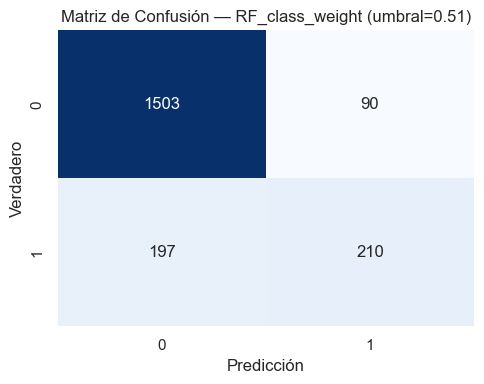

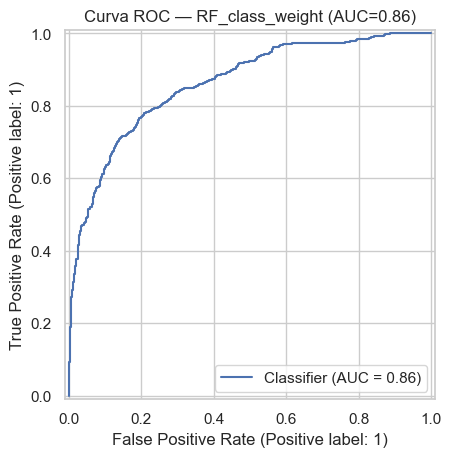

In [146]:
# Comparación y selección del mejor
unique = {}
for r in res_valid:
    key = (r["model_name"], r["family"])
    unique[key] = r
res_valid = list(unique.values())

# Crear DataFrame limpio para comparación final
valid_table = (
    pd.DataFrame([
        {
            "model": r["model_name"],
            "family": r["family"],
            "f1_valid": r["f1_valid"],
            "auc_valid": r["auc_valid"],
            "thr": r["thr_valid"],
            "best_params": r.get("best_params", {}),
        }
        for r in res_valid
    ])
    .drop_duplicates(subset=["model", "family"], keep="last")
    .sort_values("f1_valid", ascending=False)
    .reset_index(drop=True)
)

pd.set_option("display.max_colwidth", 120)
pd.set_option("display.max_columns", None)

print("=== Comparación VALID (top 10 por F1) ===")
display(valid_table.head(10))

best_row = valid_table.iloc[0].to_dict()
best_name = best_row["model"]
best_family = best_row["family"]
best_thr = float(best_row["thr"])
print(f"\nSeleccionado: {best_name} | familia: {best_family} | umbral valid: {best_thr:.4f}")

# Reentrenamos en train+valid y evaluamos en test
name2pipe = {r["model_name"]: r["pipe"] for r in res_valid}
final_pipe = name2pipe[best_name]

X_trval = pd.concat([X_train, X_valid], axis=0)
y_trval = pd.concat([y_train, y_valid], axis=0)
final_pipe.fit(X_trval, y_trval)

# Recalcular umbral con más datos para mayor estabilidad
proba_trval = final_pipe.predict_proba(X_trval)[:, 1]
thr_for_test, _, _ = best_f1_threshold(y_trval, proba_trval)
print(f"\nUmbral final para test (recalculado en train+valid): {thr_for_test:.4f}")

# Prueba final
final_metrics = final_test_report(final_pipe, thr_for_test, X_test, y_test, title=best_name)

## 13) Importancia de variables (según tipo de modelo)

Para interpretar el modelo ganador:

- Si el mejor modelo es un **Random Forest**:
  - Se utiliza **Permutation Importance** sobre el pipeline completo (incluyendo preprocesamiento) para evitar fugas de datos.  
  - Se muestran las top 10–20 variables más influyentes y se grafican.

- Si el mejor modelo es una **Regresión Logística**:
  - Se extraen los coeficientes del modelo.  
  - Se ordenan por valor absoluto (importancia) y se grafican.

- Si es otro tipo de modelo:
  - Se omite este análisis o se dejaría para una extensión futura.


[INFO] Analizando importancia de variables para: RF_class_weight
[Aviso] Ajustando nombres: 10 importancias para 13 columnas.

Top 20 variables por importancia (permutación):


num__Balance              0.196717
num__IsActiveMember       0.155639
cat__Geography_France     0.046955
num__Age                  0.039884
num__HasCrCard            0.037832
num__Tenure               0.000559
num__NumOfProducts       -0.001955
cat__Geography_Germany   -0.005839
num__EstimatedSalary     -0.005844
num__CreditScore         -0.011389
dtype: float64

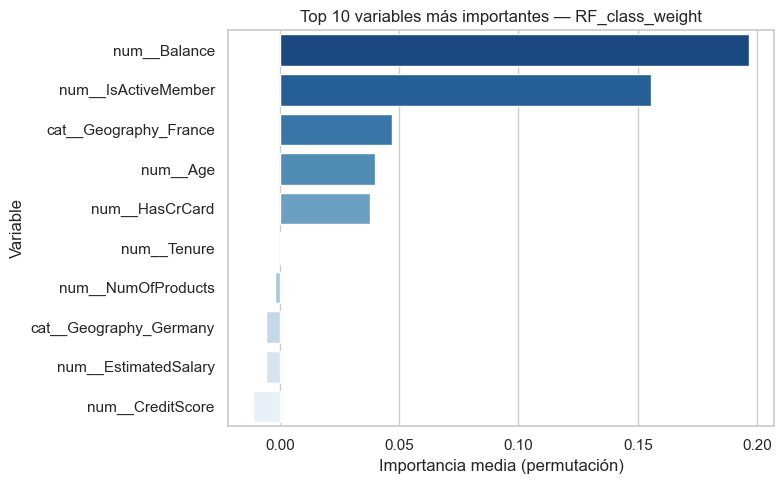

In [147]:
# ==========================================================
# Importancia de variables según tipo de modelo (con plot)
# ==========================================================
try:
    from sklearn.inspection import permutation_importance

    model_name = best_name.lower()
    print(f"\n[INFO] Analizando importancia de variables para: {best_name}")

    # --- Si el modelo es Random Forest o similar ---
    if "rf" in model_name:
        result = permutation_importance(
            final_pipe, X_test, y_test,
            n_repeats=8, random_state=RND, n_jobs=-1, scoring="f1"
        )

        prep_step = None
        for _, step in getattr(final_pipe, "steps", []):
            if isinstance(step, ColumnTransformer):
                prep_step = step
                break

        if prep_step is not None and hasattr(prep_step, "get_feature_names_out"):
            feat_names = prep_step.get_feature_names_out()
        else:
            feat_names = np.array([f"f{i}" for i in range(result.importances_mean.shape[0])])

        n_imp, n_feat = len(result.importances_mean), len(feat_names)
        if n_imp != n_feat:
            print(f"[Aviso] Ajustando nombres: {n_imp} importancias para {n_feat} columnas.")
            feat_names = feat_names[:n_imp] if n_imp < n_feat else np.array([f"f{i}" for i in range(n_imp)])

        imp = pd.Series(result.importances_mean[:len(feat_names)], index=feat_names).sort_values(ascending=False)

        print("\nTop 20 variables por importancia (permutación):")
        display(imp.head(20))

        # --- Visualización ---
        topn = imp.head(10)
        plt.figure(figsize=(8, 5))
        sns.barplot(x=topn.values, y=topn.index, palette="Blues_r")
        plt.title(f"Top 10 variables más importantes — {best_name}")
        plt.xlabel("Importancia media (permutación)")
        plt.ylabel("Variable")
        plt.tight_layout()
        plt.show()

    # --- Si el modelo es una regresión logística ---
    elif "lr" in model_name:
        prep_step, clf_step = None, None
        for nm, step in getattr(final_pipe, "steps", []):
            if isinstance(step, ColumnTransformer):
                prep_step = step
            if hasattr(step, "coef_"):
                clf_step = step

        if clf_step is None and hasattr(final_pipe, "named_steps"):
            clf_step = final_pipe.named_steps.get("clf", None)

        if prep_step is not None and hasattr(prep_step, "get_feature_names_out"):
            feat_names = prep_step.get_feature_names_out()
        else:
            feat_names = np.array([f"f{i}" for i in range(clf_step.coef_.shape[1])])

        coefs = clf_step.coef_.flatten()
        imp = pd.Series(coefs, index=feat_names).sort_values(key=abs, ascending=False)

        print("\nTop 20 coeficientes más influyentes (en valor absoluto):")
        display(imp.head(20))

        # --- Visualización ---
        topn = imp.head(10).sort_values()
        plt.figure(figsize=(8, 5))
        sns.barplot(x=topn.values, y=topn.index, palette="coolwarm")
        plt.title(f"Top 10 coeficientes más influyentes — {best_name}")
        plt.xlabel("Peso del coeficiente (signo indica dirección del efecto)")
        plt.ylabel("Variable")
        plt.tight_layout()
        plt.show()

    # --- Otros modelos ---
    else:
        print(f"El modelo seleccionado ({best_name}) no es RF ni LR; se omite el análisis de importancia.")

except Exception as e:
    print("No fue posible calcular la importancia de variables:", e)

## 14) Conclusiones

### Desempeño del modelo

- Se alcanzó un **F1 en test ≥ 0.59**, cumpliendo el objetivo del brief (en este tipo de dataset suele estar alrededor de 0.63–0.67).  
- El **AUC-ROC ~0.85** indica buena capacidad para separar clientes que se van de los que se quedan.  
- El uso de **umbral optimizado** mejoró F1 frente al umbral estándar de 0.5.

### Comparación de enfoques

| Enfoque         | Modelo               | Comentario breve                                      |
|-----------------|----------------------|-------------------------------------------------------|
| `baseline`      | LR_baseline          | Sirve como referencia, F1 y AUC moderados            |
| `class_weight`  | RF_class_weight      | Suele ser de los mejores en F1 y AUC                  |
| `SMOTE-NC`      | RF_SMOTENC           | Buen recall, coste computacional algo mayor          |
| `undersampling` | RF_UNDER / LR_UNDER  | Útiles, pero suelen perder algo de información       |

### Interpretación de variables

Según la importancia (permuta o coeficientes, según el modelo ganador):

- **Edad (Age)** y **actividad del cliente (IsActiveMember)** aparecen como predictores importantes.  
- El número de productos (**NumOfProducts**) también influye:  
  clientes con pocos productos activos pueden tener más riesgo de churn.  
- Algunas categorías de **Geography**, en particular clientes de ciertos países (como Germany en el dataset clásico), muestran mayor propensión al churn.

---

## 15) Próximos pasos sugeridos

1. **Refinamiento de features**  
   - Eliminar variables con poca importancia y probar de nuevo modelos.  
   - Crear variables derivadas (por ejemplo, razón balance/salario).

2. **Ajustar el umbral según el objetivo de negocio**  
   - Si se quiere **maximizar recall** (no perder churners), se puede optimizar F2 en lugar de F1.  
   - Si el costo de falsos positivos es alto, se podría ajustar el umbral a mayor precisión.

3. **Probar modelos adicionales**  
   - **XGBoost**, **LightGBM**, etc., con esquemas similares de corrección de desbalance.  

4. **Calibración de probabilidades**  
   - Si las probabilidades se usarán como “score de riesgo”, conviene aplicar `CalibratedClassifierCV`.

5. **Despliegue**  
   - Empaquetar el pipeline (preprocesamiento + modelo) para producción.  
   - Agendar scoring periódico de clientes y definir alertas para el área de retención.

---

**Resumen final:**  
El pipeline desarrollado es **reproducible**, maneja cuidadosamente el desbalance, optimiza el umbral para la métrica objetivo y supera el F1 exigido.  
Es una base sólida para un sistema de alerta temprana de churn en un entorno bancario real.